In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms
# from torchvision.transforms import PILToTensor
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from torchmetrics import Accuracy

import matplotlib.pyplot as plt
from pathlib import Path
import random
import kagglehub
import pandas
import numpy as np

from PIL import Image

import requests
import zipfile
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
device

/home/redux/Documents/PyTorch/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


In [3]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [4]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'


In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [6]:
image_path

PosixPath('data/pizza_steak_sushi')

Random Image Path: data/pizza_steak_sushi/test/sushi/2741434.jpg
Image Class: sushi
Image height: 512
Image width: 512


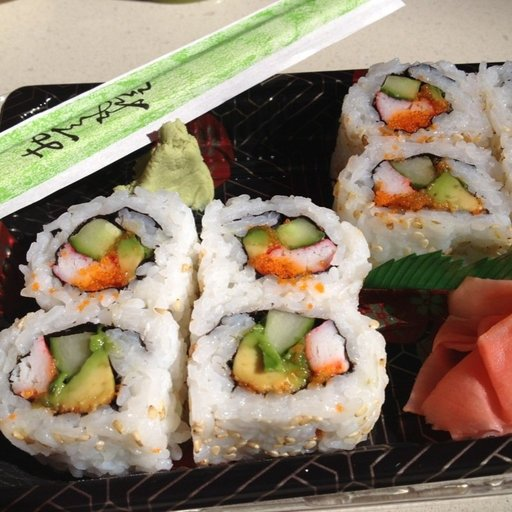

In [7]:
random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg")) # * (train, or test) / * (pizza, steak or sushi) / *.jpg (all the files ending in .jpg)

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random Image Path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

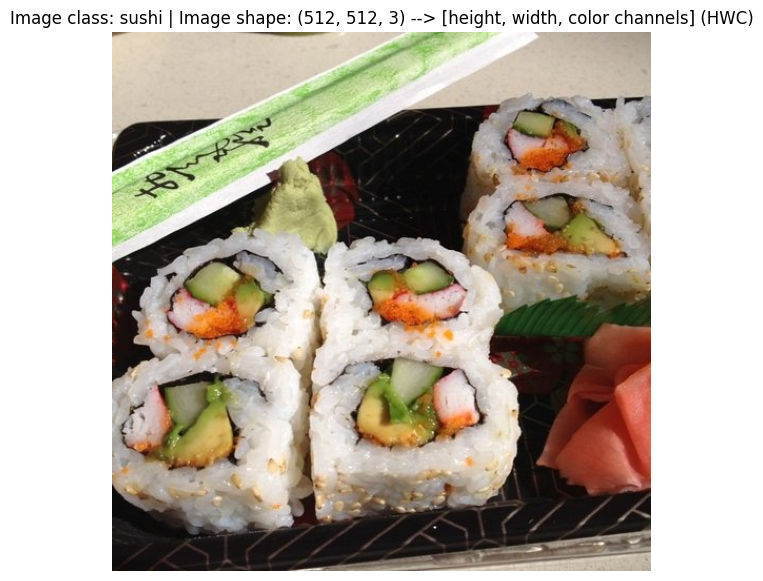

In [8]:
img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} --> [height, width, color channels] (HWC)")
plt.axis(False)

In [9]:
img_as_array

array([[[120,  94,  67],
        [120,  94,  67],
        [120,  94,  67],
        ...,
        [161, 149, 135],
        [161, 149, 135],
        [162, 150, 136]],

       [[122,  96,  69],
        [121,  95,  68],
        [120,  94,  67],
        ...,
        [162, 150, 136],
        [163, 151, 137],
        [164, 152, 138]],

       [[131, 107,  81],
        [133, 109,  83],
        [136, 112,  86],
        ...,
        [164, 152, 138],
        [165, 153, 139],
        [166, 154, 140]],

       ...,

       [[ 18,  15,  10],
        [ 18,  15,  10],
        [ 19,  14,  10],
        ...,
        [177, 168, 151],
        [183, 176, 158],
        [181, 174, 156]],

       [[ 20,  15,   9],
        [ 22,  17,  11],
        [ 28,  20,  17],
        ...,
        [177, 168, 151],
        [178, 171, 153],
        [175, 168, 150]],

       [[ 21,  16,  10],
        [ 27,  22,  16],
        [ 35,  27,  24],
        ...,
        [186, 177, 160],
        [181, 174, 156],
        [175, 168, 150]]

In [10]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),           # Resize the images to 64 x 64
    transforms.RandomHorizontalFlip(p=0.5),     # The images have 50% chances to be horizontally flipped
    transforms.ToTensor()                       # Turn the image into a tensor
])

In [11]:
data_transform(img)

tensor([[[0.6549, 0.6627, 0.6745,  ..., 0.8863, 0.8392, 0.7686],
         [0.6784, 0.6863, 0.6941,  ..., 0.8941, 0.8941, 0.9020],
         [0.7020, 0.7098, 0.7176,  ..., 0.8863, 0.8941, 0.8980],
         ...,
         [0.6039, 0.6196, 0.5961,  ..., 0.0902, 0.0745, 0.0706],
         [0.7294, 0.7412, 0.7490,  ..., 0.0980, 0.0824, 0.0627],
         [0.7255, 0.7490, 0.7529,  ..., 0.0588, 0.0745, 0.0745]],

        [[0.6078, 0.6157, 0.6275,  ..., 0.8314, 0.7765, 0.6941],
         [0.6314, 0.6392, 0.6471,  ..., 0.8353, 0.8392, 0.8431],
         [0.6549, 0.6627, 0.6667,  ..., 0.8275, 0.8353, 0.8392],
         ...,
         [0.5686, 0.5765, 0.5529,  ..., 0.0784, 0.0667, 0.0627],
         [0.6941, 0.6980, 0.7059,  ..., 0.0784, 0.0667, 0.0588],
         [0.6941, 0.7098, 0.7098,  ..., 0.0510, 0.0549, 0.0588]],

        [[0.5529, 0.5608, 0.5725,  ..., 0.7373, 0.6824, 0.5922],
         [0.5765, 0.5843, 0.5922,  ..., 0.7451, 0.7451, 0.7451],
         [0.6000, 0.6078, 0.6078,  ..., 0.7412, 0.7412, 0.

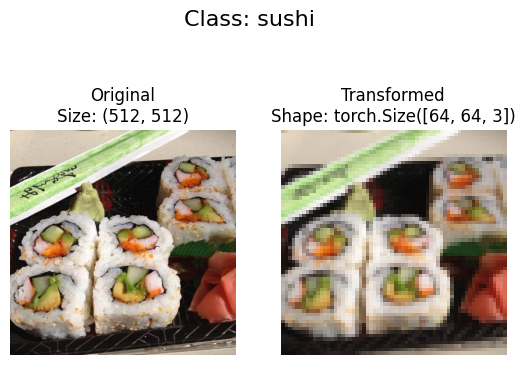

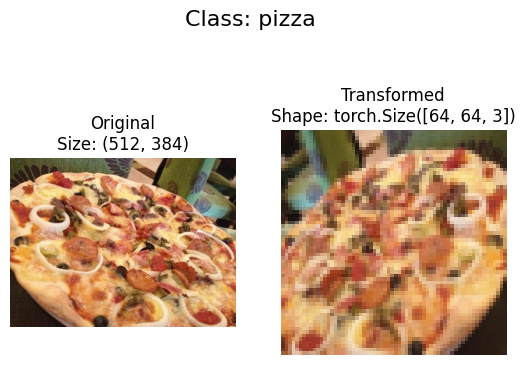

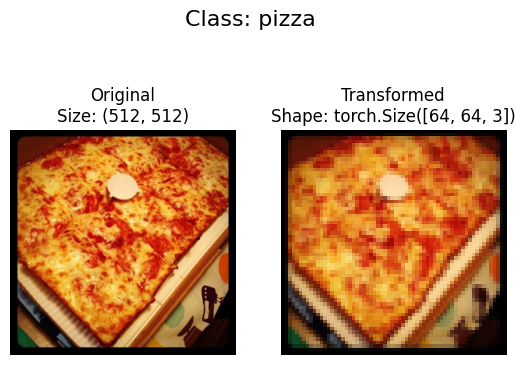

In [12]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

In [13]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [23]:
len(train_data), len(test_data)

(225, 75)

In [24]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image Tensor:\n{img}")
print(f"Image Shape: {img.shape}")
print(f"Image Datatype: {img.dtype}")
print(f"Image Label: {label}")
print(f"Label Datatype: {type(label)}")

Image Tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original Shape: torch.Size([3, 64, 64]) --> [color channels, height, width]
Permuted Shape: torch.Size([64, 64, 3]) --> [height, width, color channels]


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

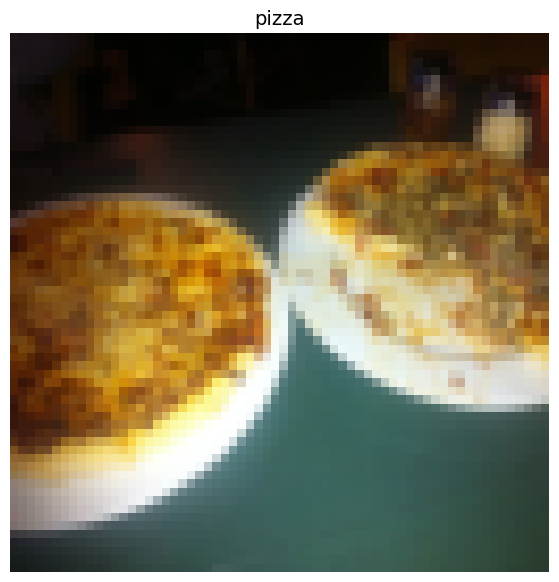

In [25]:
img_permute = img.permute(1, 2, 0)

print(f"Original Shape: {img.shape} --> [color channels, height, width]")
print(f"Permuted Shape: {img_permute.shape} --> [height, width, color channels]")

plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.title(class_names[label], fontsize=14)
plt.axis(False)

In [26]:
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ec9d002dca0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ec9d002f440>)

In [118]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [119]:
img, label = next(iter(train_dataloader))

print(f"Image Shape: {img.shape} --> [batch size, color channels, height, width]")
print(f"Label Shape: {label.shape}")

Image Shape: torch.Size([1, 3, 64, 64]) --> [batch size, color channels, height, width]
Label Shape: torch.Size([1])


In [44]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [123]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [129]:
target_directory = train_dir
print(f"Target Dir: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target Dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [134]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory."""

    classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

In [135]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [184]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir: str, transform=None) -> None:
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)
    
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [185]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [186]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x72dd3f468620>,
 <__main__.ImageFolderCustom at 0x72dbe1bcf2f0>)

In [187]:
len(train_data), len(train_data_custom)

(225, 225)

In [188]:
len(test_data), len(test_data_custom)

(75, 75)

In [189]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [190]:
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


In [191]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16, 8))

    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        plt.subplot(1, n, i + 1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

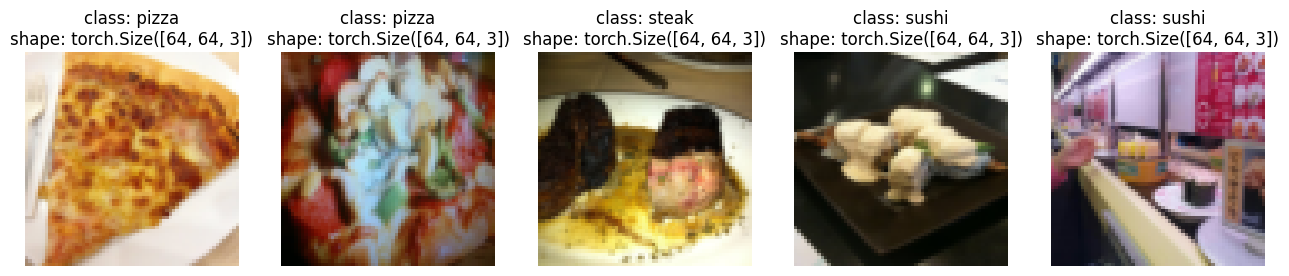

In [202]:
display_random_images(dataset=train_data,
                      classes=class_names,
                      n=5,
                      display_shape=True,
                      seed=None)

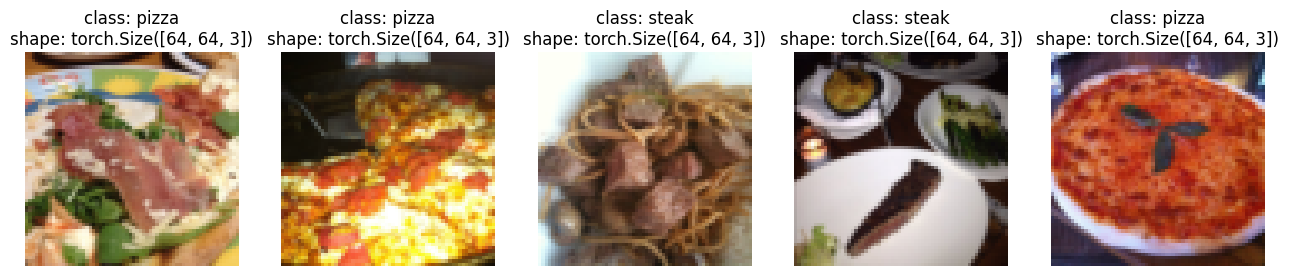

In [205]:
display_random_images(dataset=train_data_custom,
                      classes=class_names,
                      n=5,
                      display_shape=True,
                      seed=None)

In [214]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x72dbe1fb6d80>,
 <torch.utils.data.dataloader.DataLoader at 0x72dbe1a4b620>)

In [219]:
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [256]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # TrivialAugmentWide is one way of transforming the image applying diversity to it. This allows the model to better generalize patterns
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [257]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/pizza/2124579.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/540882.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3475871.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/309892.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/398345.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/971934.jpg')]

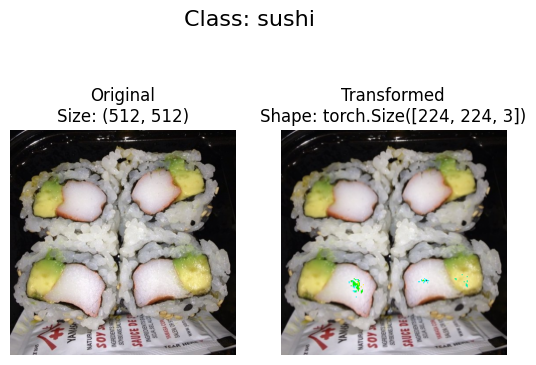

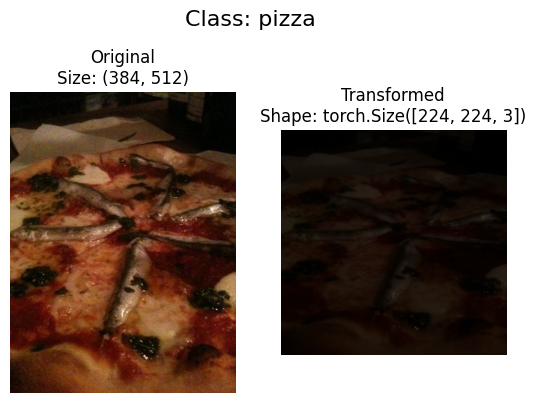

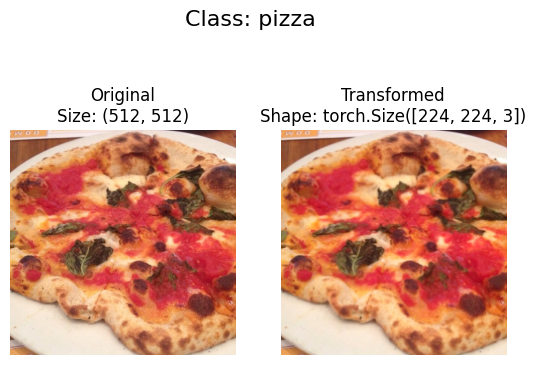

In [259]:
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=None)

In [16]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [17]:
train_data_simple = datasets.ImageFolder(root=train_dir,
                                  transform=simple_transform,
                                  target_transform=None)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                 transform=simple_transform)

BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

In [18]:
len(train_data_simple), len(test_data_simple)

(225, 75)

In [120]:
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 14 * 14,
                      out_features=output_shape)
        )
    
    def forward(self, x):
        return self.classifier(self.conv_layer_2(self.conv_layer_1(x)))

In [146]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=24,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(24, 24, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(24, 24, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(24, 24, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4704, out_features=3, bias=True)
  )
)

In [147]:
model_0(train_data[0][0].unsqueeze(dim=0).to(device))

tensor([[-0.0230, -0.0011, -0.0530]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [148]:
from torchinfo import summary

summary(model=model_0,
        input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 24, 31, 31]           --
│    └─Conv2d: 2-1                       [1, 24, 63, 63]           312
│    └─ReLU: 2-2                         [1, 24, 63, 63]           --
│    └─Conv2d: 2-3                       [1, 24, 62, 62]           2,328
│    └─ReLU: 2-4                         [1, 24, 62, 62]           --
│    └─MaxPool2d: 2-5                    [1, 24, 31, 31]           --
├─Sequential: 1-2                        [1, 24, 14, 14]           --
│    └─Conv2d: 2-6                       [1, 24, 30, 30]           2,328
│    └─ReLU: 2-7                         [1, 24, 30, 30]           --
│    └─Conv2d: 2-8                       [1, 24, 29, 29]           2,328
│    └─ReLU: 2-9                         [1, 24, 29, 29]           --
│    └─MaxPool2d: 2-10                   [1, 24, 14, 14]           --
├─Seq

In [149]:
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn: torchmetrics.Accuracy,
               device: torch.device = device):
    
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc*100

def test_step(model: nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              accuracy_fn: torchmetrics.Accuracy,
              device: torch.device = device):
    
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            
            test_loss += loss_fn(y_pred, y)
            test_acc += accuracy_fn(y_pred.argmax(dim=1), y)
    
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    return test_loss, test_acc*100

In [150]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints difference between start and end time"""
    total_time = end - start
    print(f"Train on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
def train(model: nn.Module,
          epochs: int,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          accuracy_fn: torchmetrics.Accuracy,
          device: torch.device = device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    for epoch in range(epochs):

        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           accuracy_fn=accuracy_fn,
                                           device=device)

        test_loss, test_acc = test_step(model=model,
                                        data_loader=test_dataloader,
                                        loss_fn=loss_fn,
                                        accuracy_fn=accuracy_fn,
                                        device=device)

        # print("=" * 40 + "\n")
        print(f"Epoch: {epoch:2} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
        results["train_loss"].append(train_loss.item())
        results["train_acc"].append(train_acc.item())
        results["test_loss"].append(test_loss.item())
        results["test_acc"].append(test_acc.item())
    
    return results

In [152]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=64,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.0005)
accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

from timeit import default_timer as timer 
start_time = timer()

model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        accuracy_fn=accuracy_fn,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Epoch:  0 | Train Loss: 1.1115 | Train Accuracy: 31.2500 | Test Loss: 1.0842 | Test Accuracy: 31.2500
Epoch:  1 | Train Loss: 1.0800 | Train Accuracy: 32.0833 | Test Loss: 1.0456 | Test Accuracy: 50.6818
Epoch:  2 | Train Loss: 0.9261 | Train Accuracy: 62.9167 | Test Loss: 1.0787 | Test Accuracy: 36.1364
Epoch:  3 | Train Loss: 1.0053 | Train Accuracy: 55.0000 | Test Loss: 0.9915 | Test Accuracy: 52.1591
Epoch:  4 | Train Loss: 0.8568 | Train Accuracy: 67.0833 | Test Loss: 1.0084 | Test Accuracy: 49.0909
Epoch:  5 | Train Loss: 0.7951 | Train Accuracy: 70.0000 | Test Loss: 1.0010 | Test Accuracy: 48.9773
Epoch:  6 | Train Loss: 0.7285 | Train Accuracy: 67.9167 | Test Loss: 1.0399 | Test Accuracy: 47.8409
Epoch:  7 | Train Loss: 0.7344 | Train Accuracy: 65.4167 | Test Loss: 1.0604 | Test Accuracy: 48.9773
Epoch:  8 | Train Loss: 0.7023 | Train Accuracy: 71.2500 | Test Loss: 1.0645 | Test Accuracy: 41.1364
Epoch:  9 | Train Loss: 0.6875 | Train Accuracy: 67.9167 | Test Loss: 1.0923 | Tes

In [138]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [77]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();


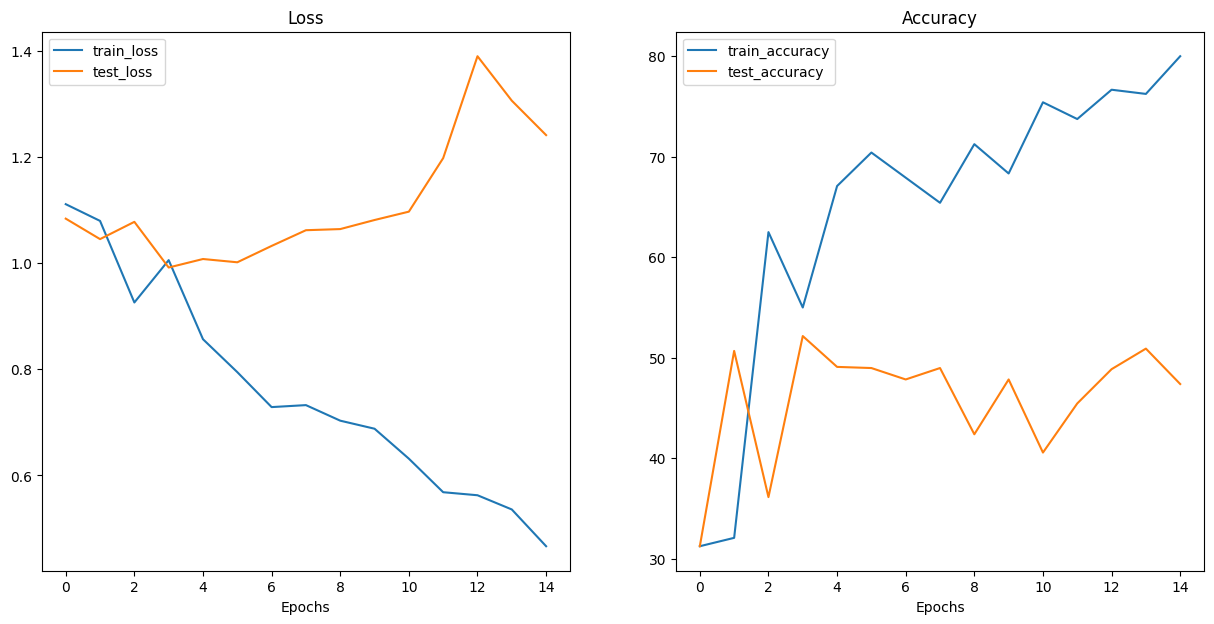

In [139]:
plot_loss_curves(model_0_results)

In [140]:
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform_trivial_augment = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_data_augment = datasets.ImageFolder(root=train_dir,
                                          transform=train_transform_trivial_augment,
                                          target_transform=None)
test_data_augment = datasets.ImageFolder(root=test_dir,
                                         transform=test_transform_trivial_augment)

train_data_augment, test_data_augment

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [141]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(dataset=train_data_augment,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=True)
test_dataloader_augmented = DataLoader(dataset=test_data_augment,
                                       batch_size=BATCH_SIZE,
                                       num_workers=NUM_WORKERS,
                                       shuffle=False)

len(train_dataloader_augmented), test_dataloader_augmented

(8, <torch.utils.data.dataloader.DataLoader at 0x7da765166f30>)

In [142]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=64,
                  output_shape=len(train_data_augment.classes)).to(device)
model_1

TinyVGG(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12544, out_features=3, bias=True)
  )
)

In [144]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 15

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.0005)
accuracy_fn = Accuracy(task="multiclass", num_classes=len(train_data_augment.classes)).to(device)

start_time = timer()

model_1_results = train(model=model_1,
                        epochs=EPOCHS,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_augmented,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        accuracy_fn=accuracy_fn,
                        device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Epoch:  0 | Train Loss: 1.1143 | Train Accuracy: 31.2500 | Test Loss: 1.0987 | Test Accuracy: 29.1667
Epoch:  1 | Train Loss: 1.0666 | Train Accuracy: 42.5781 | Test Loss: 1.1188 | Test Accuracy: 26.0417
Epoch:  2 | Train Loss: 1.0671 | Train Accuracy: 41.4062 | Test Loss: 1.1365 | Test Accuracy: 27.0833
Epoch:  3 | Train Loss: 1.0294 | Train Accuracy: 50.0000 | Test Loss: 1.1176 | Test Accuracy: 26.0417
Epoch:  4 | Train Loss: 0.9676 | Train Accuracy: 55.0781 | Test Loss: 1.0790 | Test Accuracy: 32.1970
Epoch:  5 | Train Loss: 1.0756 | Train Accuracy: 38.6719 | Test Loss: 1.0163 | Test Accuracy: 34.0909
Epoch:  6 | Train Loss: 0.9511 | Train Accuracy: 56.6406 | Test Loss: 1.0144 | Test Accuracy: 44.4129
Epoch:  7 | Train Loss: 0.9692 | Train Accuracy: 57.4219 | Test Loss: 1.0826 | Test Accuracy: 30.1136
Epoch:  8 | Train Loss: 0.9824 | Train Accuracy: 44.5312 | Test Loss: 1.0546 | Test Accuracy: 39.2992
Epoch:  9 | Train Loss: 0.9544 | Train Accuracy: 44.9219 | Test Loss: 0.9603 | Tes

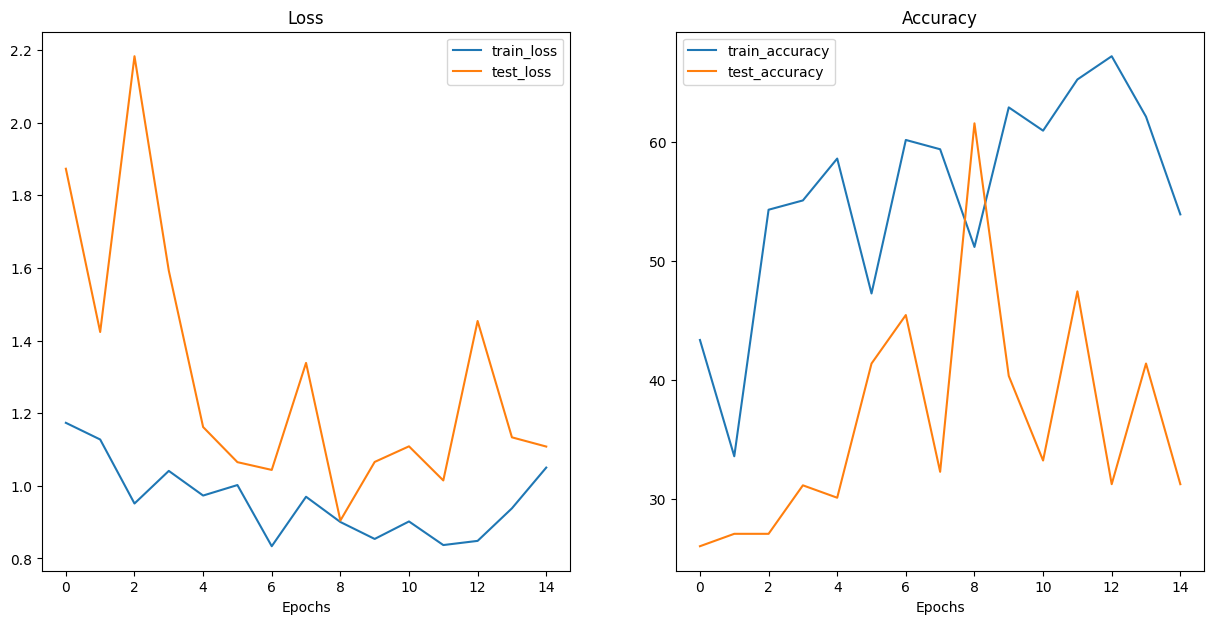

In [107]:
plot_loss_curves(model_1_results)

In [87]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.108295,31.666670,1.093717,31.250000
1,1.087829,40.000004,1.069335,42.840912
2,1.102826,40.833336,1.076671,38.636364
3,1.080087,46.666672,1.060662,31.250000
4,0.956246,56.666672,1.005849,34.204544


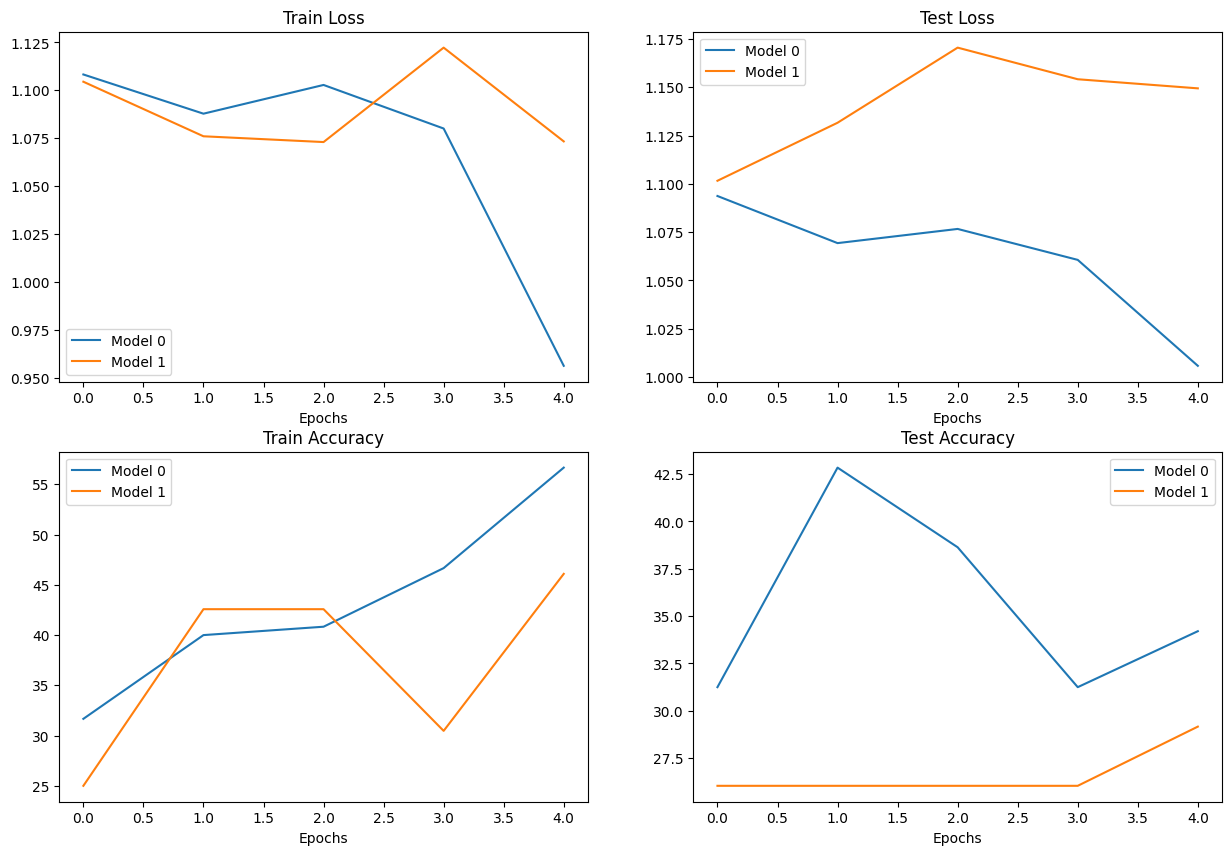

In [88]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();